In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout

Using TensorFlow backend.


In [2]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

In [3]:
data = pd.read_csv('pollution.csv', header=0, index_col=0)
data.head(10)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
2010-01-02 05:00:00,109.0,-7,-6.0,1022.0,SE,7.14,3,0
2010-01-02 06:00:00,105.0,-7,-6.0,1023.0,SE,8.93,4,0
2010-01-02 07:00:00,124.0,-7,-5.0,1024.0,SE,10.72,0,0
2010-01-02 08:00:00,120.0,-8,-6.0,1024.0,SE,12.51,0,0


In [4]:
values = data.values

groups = [0, 1, 2, 3, 5, 6, 7]

i = 1

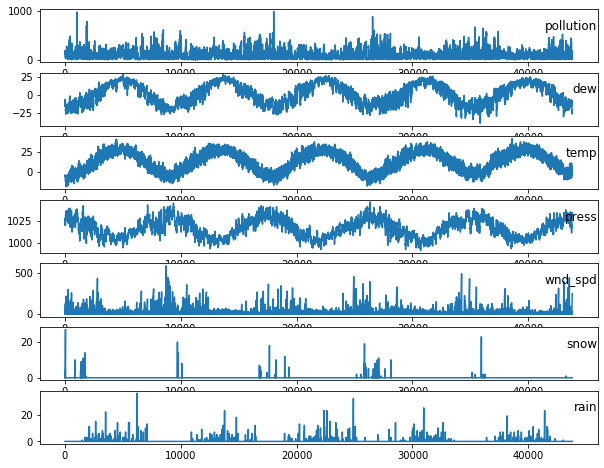

In [5]:
plt.figure(figsize=(10,8))

for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
label_encoder = LabelEncoder()
data.iloc[:,4] = label_encoder.fit_transform(data.iloc[:,4])
values = data.values
print(values.shape)
values = values.astype('float32')

(43800, 8)


In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled,1,1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


In [10]:
X = reframed.loc[:,[
    'var1(t-1)',
    'var2(t-1)',
    'var3(t-1)',
    'var4(t-1)',
    'var5(t-1)',
    'var6(t-1)',
    'var7(t-1)',
    'var8(t-1)',
]]

Y = reframed.loc[:,['var1(t)']]

In [11]:
print(X.shape, Y.shape)

(43799, 8) (43799, 1)


In [12]:
def split_data(x, y, train_size):
    x_train = x[:int(len(x)*train_size)]
    x_test = x[int(len(x)*train_size):]
    y_train = y[:int(len(y)*train_size)]
    y_test = y[int(len(y)*train_size):]
    return x_train, x_test, y_train, y_test

In [13]:
x_train, x_test, y_train, y_test = split_data(X, Y, train_size=0.7)

In [14]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(30659, 8) (13140, 8) (30659, 1) (13140, 1)


In [15]:
model = Sequential()
model.add(Conv1D(filters=10, kernel_size=2, activation='relu', input_shape=(8, 1)))
model.add(Conv1D(filters=10, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

W0627 15:55:42.544424 140299935659840 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0627 15:55:42.564116 140299935659840 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0627 15:55:42.567641 140299935659840 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0627 15:55:42.758215 140299935659840 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [16]:
model.compile(optimizer='adam', loss='mse')

W0627 15:56:01.925512 140299935659840 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [17]:
X = np.expand_dims(X, axis=2)

In [18]:
print(X.shape)

(43799, 8, 1)


In [19]:
model.fit(X, Y, epochs=100, verbose=0)

W0627 15:56:42.618220 140299935659840 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0627 15:56:42.738500 140299935659840 deprecation_wrapper.py:119] From /home/lucas/LICA/LICA/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



In [20]:
x_test = np.expand_dims(x_test, axis=2)

In [21]:
pred = model.predict(x_test)

In [22]:
from sklearn.metrics import mean_squared_error

print(np.sqrt(mean_squared_error(y_test, pred)).round(5))

0.02333


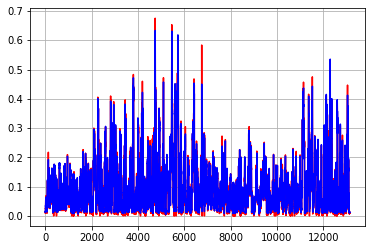

In [23]:
plt.plot(y_test.reset_index(drop=True), 'r')
plt.plot(pred, 'b')
plt.grid(True)